In [1]:
library(Seurat)
library(Signac)
library(magrittr)
library(ggplot2)
library(BiocIO)
library(genomation)
library(Rsamtools)
library(parallel)
library(foreach)

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.3.2 but the current version is
4.3.3; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Loading required package: grid

Warning message:
“replacing previous import ‘Biostrings::pattern’ by ‘grid::pattern’ when loading ‘genomation’”
Loading required package: GenomeInfoDb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    a

Specify file paths

In [2]:
names.sample = c("Multiome10x_03",
                 "Multiome10x_04",
                 "Multiome10x_05",
                 "Multiome10x_06")

paths.meta = c("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/10x/cellranger_res/Multiome10x_03/outs/per_barcode_metrics.csv",
               "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/10x/cellranger_res/Multiome10x_04/outs/per_barcode_metrics.csv",
               "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/10x/cellranger_res/Multiome10x_05/outs/per_barcode_metrics.csv",
               "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/10x/cellranger_res/Multiome10x_06/outs/per_barcode_metrics.csv")

paths.matrix = c("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/10x/cellranger_res/Multiome10x_03/outs/raw_feature_bc_matrix/",
                 "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/10x/cellranger_res/Multiome10x_04/outs/raw_feature_bc_matrix/",
                 "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/10x/cellranger_res/Multiome10x_05/outs/raw_feature_bc_matrix/",
                 "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/10x/cellranger_res/Multiome10x_06/outs/raw_feature_bc_matrix/")

paths.fragments = c("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/10x/cellranger_res/Multiome10x_03/outs/atac_fragments.tsv.gz",
                    "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/10x/cellranger_res/Multiome10x_04/outs/atac_fragments.tsv.gz",
                    "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/10x/cellranger_res/Multiome10x_05/outs/atac_fragments.tsv.gz",
                    "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/10x/cellranger_res/Multiome10x_06/outs/atac_fragments.tsv.gz")


Import meta data

In [3]:
list.meta = list()
for (n.tmp in 1:length(names.sample)) {
  meta.tmp =
    read.csv(paths.meta[n.tmp],
             stringsAsFactors = F)
  meta.tmp$sample = names.sample[n.tmp]
  meta.tmp$sample_barcode = paste(names.sample[n.tmp],
                                  meta.tmp$barcode,
                                  sep = "_")
  list.meta[[names.sample[n.tmp]]] = meta.tmp
  rm(meta.tmp)
}
meta.merge = do.call(rbind,list.meta)
row.names(meta.merge) = meta.merge$sample_barcode
rm(list.meta)

Import matrix

In [4]:
list.matrix = list()
for (n.tmp in 1:length(names.sample)) {
  matrix.tmp = Read10X(data.dir = paths.matrix[n.tmp])
  colnames(matrix.tmp$`Gene Expression`) =
    paste(names.sample[n.tmp],
          colnames(matrix.tmp$`Gene Expression`),
          sep = "_")
  colnames(matrix.tmp$Peaks) =
    paste(names.sample[n.tmp],
          colnames(matrix.tmp$Peaks),
          sep = "_")
  list.matrix[[names.sample[n.tmp]]] = matrix.tmp
  rm(matrix.tmp)
}

10X data contains more than one type and is being returned as a list containing matrices of each type.

10X data contains more than one type and is being returned as a list containing matrices of each type.

10X data contains more than one type and is being returned as a list containing matrices of each type.

10X data contains more than one type and is being returned as a list containing matrices of each type.



In [5]:
bc.qc = meta.merge[meta.merge$is_cell == 1,"sample_barcode"]

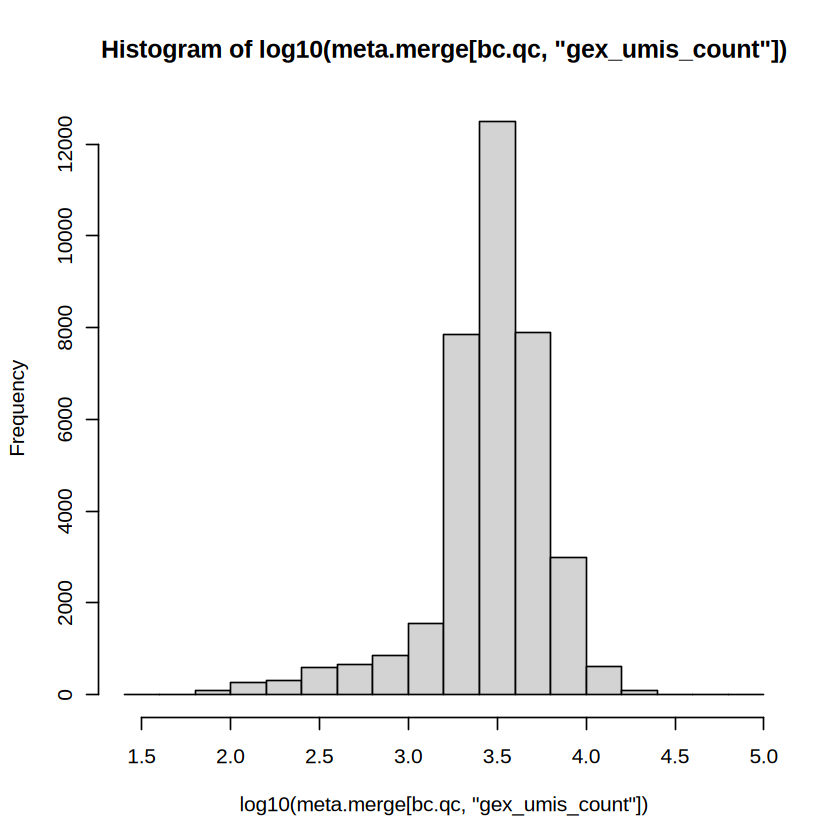

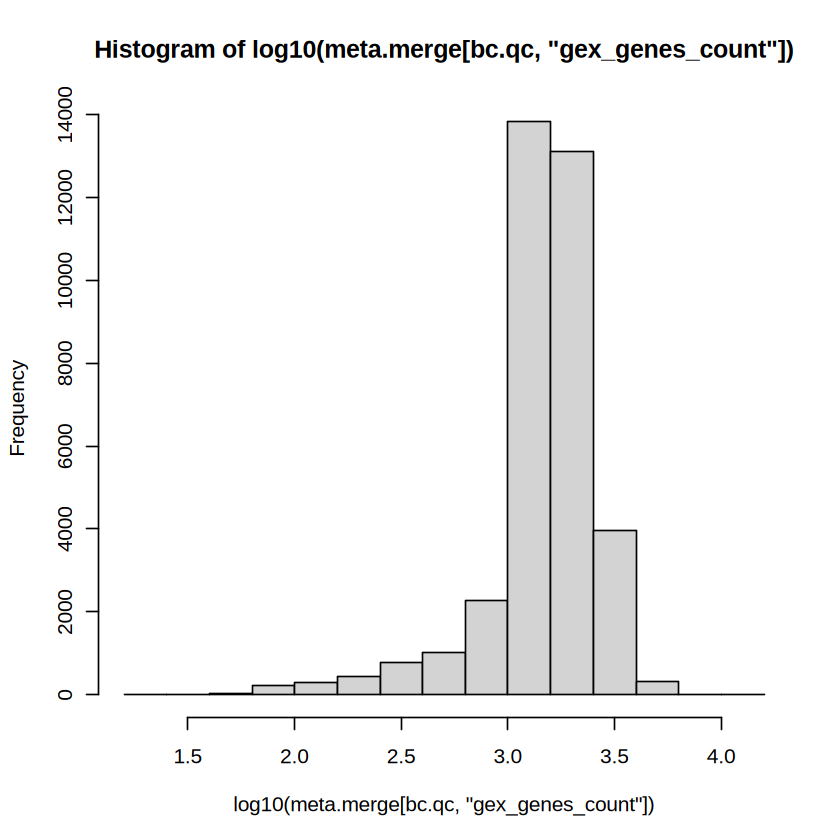

In [6]:
hist(log10(meta.merge[bc.qc,"gex_umis_count"]))
hist(log10(meta.merge[bc.qc,"gex_genes_count"]))

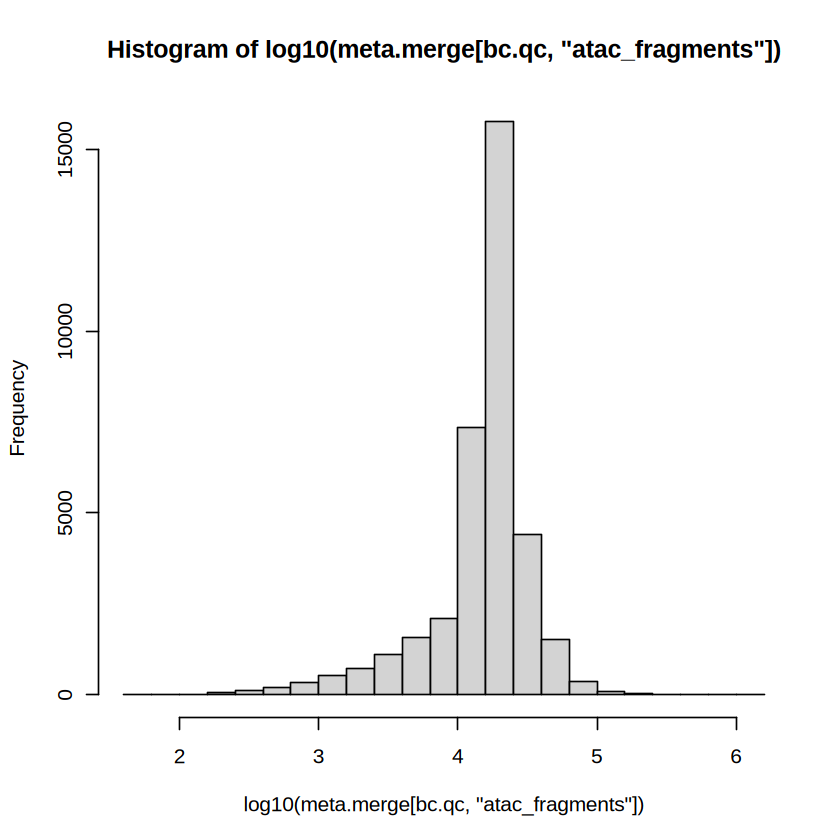

In [7]:
hist(log10(meta.merge[bc.qc,"atac_fragments"]))

In [8]:
bc.qc.filter = bc.qc[log10(meta.merge[bc.qc,"gex_umis_count"]) > 3 &
                         log10(meta.merge[bc.qc,"atac_fragments"]) > 3]
length(bc.qc.filter)

[1] 32797

In [9]:
meta.merge.filter = meta.merge[bc.qc.filter,]
dim(meta.merge.filter)
meta.merge.filter

[1] 32797    33

,barcode,gex_barcode,atac_barcode,is_cell,excluded_reason,gex_raw_reads,gex_mapped_reads,gex_conf_intergenic_reads,gex_conf_exonic_reads,gex_conf_intronic_reads,⋯,atac_lowmapq,atac_dup_reads,atac_chimeric_reads,atac_mitochondrial_reads,atac_fragments,atac_TSS_fragments,atac_peak_region_fragments,atac_peak_region_cutsites,sample,sample_barcode
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
Multiome10x_03_AAACAGCCAAATATCC-1,AAACAGCCAAATATCC-1,AAACAGCCAAATATCC-1,ACAGCGGGTTGTGACT-1,1,0,58263,56118,1219,34082,17918,⋯,1329,5500,29,22,8953,5938,6791,12763,Multiome10x_03,Multiome10x_03_AAACAGCCAAATATCC-1
Multiome10x_03_AAACAGCCAGGAACTG-1,AAACAGCCAGGAACTG-1,AAACAGCCAGGAACTG-1,ACAGCGGGTCCGTTAG-1,1,0,83734,80734,2204,39540,33425,⋯,1680,10015,52,1,17431,8768,12366,23133,Multiome10x_03,Multiome10x_03_AAACAGCCAGGAACTG-1
Multiome10x_03_AAACAGCCAGGCTTCG-1,AAACAGCCAGGCTTCG-1,AAACAGCCAGGCTTCG-1,ACAGCGGGTAACCGGG-1,1,0,46403,44796,1494,16584,24083,⋯,1786,11157,61,5,19402,9037,12283,22914,Multiome10x_03,Multiome10x_03_AAACAGCCAGGCTTCG-1
Multiome10x_03_AAACCAACACCTGCTC-1,AAACCAACACCTGCTC-1,AAACCAACACCTGCTC-1,CTTTATCGTACACCGC-1,1,0,27151,26105,719,13616,9978,⋯,1937,7040,53,16,12444,7892,9084,17113,Multiome10x_03,Multiome10x_03_AAACCAACACCTGCTC-1
Multiome10x_03_AAACCAACAGATTCAT-1,AAACCAACAGATTCAT-1,AAACCAACAGATTCAT-1,CTTTATCGTTATTTGG-1,1,0,35097,33912,973,19873,11223,⋯,1490,7824,32,39,13810,8447,9790,18404,Multiome10x_03,Multiome10x_03_AAACCAACAGATTCAT-1
Multiome10x_03_AAACCAACAGTTGCGT-1,AAACCAACAGTTGCGT-1,AAACCAACAGTTGCGT-1,CTTTATCGTGAACGGT-1,1,0,32825,31781,891,17823,11217,⋯,1603,7997,53,282,14304,8576,9980,18724,Multiome10x_03,Multiome10x_03_AAACCAACAGTTGCGT-1
Multiome10x_03_AAACCAACATAACGGG-1,AAACCAACATAACGGG-1,AAACCAACATAACGGG-1,CTTTATCGTCCTCCCA-1,1,0,77193,74763,1138,54317,14804,⋯,2275,5819,42,118,10788,7040,7543,14018,Multiome10x_03,Multiome10x_03_AAACCAACATAACGGG-1
Multiome10x_03_AAACCAACATAGACCC-1,AAACCAACATAGACCC-1,AAACCAACATAGACCC-1,CTTTATCGTAAAGGTT-1,1,0,68239,65606,1537,27024,31592,⋯,796,4593,34,1,8645,4350,6159,11622,Multiome10x_03,Multiome10x_03_AAACCAACATAGACCC-1
Multiome10x_03_AAACCGCGTGAGGTAG-1,AAACCGCGTGAGGTAG-1,AAACCGCGTGAGGTAG-1,AATAGCTCAGGACCTG-1,1,0,90091,87421,2285,47315,30671,⋯,3572,19673,83,558,30152,17520,21438,40012,Multiome10x_03,Multiome10x_03_AAACCGCGTGAGGTAG-1


In [10]:
list.matrix.rna.filter = list()
for (n.tmp in 1:length(names.sample)) {
  matrix.rna.tmp = list.matrix[[names.sample[n.tmp]]]$`Gene Expression`
  matrix.rna.tmp = matrix.rna.tmp[,colnames(matrix.rna.tmp) %in% meta.merge.filter$sample_barcode]
  list.matrix.rna.filter[[names.sample[n.tmp]]] = matrix.rna.tmp
  rm(matrix.rna.tmp)
}
matrix.rna = do.call(cbind,list.matrix.rna.filter)
matrix.rna = matrix.rna[,meta.merge.filter$sample_barcode]
dim(matrix.rna)

[1] 62757 32797

Creat seurat object

In [11]:
obj.seurat <- CreateSeuratObject(
  counts = matrix.rna,
  assay = "RNA",
  meta.data = meta.merge.filter
)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


Create a empty ChromatinAssay

In [14]:
matrix.atac.empty = matrix.rna[1:3,]
matrix.atac.empty[,] = 0
rownames(matrix.atac.empty) = c("chr1-1-100",
                                "chr2-1-100",
                                "chr3-1-100")

In [15]:
list.fragments = list()
for (n.tmp in 1:length(names.sample)) {
  cells.tmp = meta.merge.filter[meta.merge.filter$sample == names.sample[n.tmp],"barcode"]
  names(cells.tmp) = meta.merge.filter[meta.merge.filter$sample == names.sample[n.tmp],"sample_barcode"]
  list.fragments[[n.tmp]] =
    CreateFragmentObject(path = paths.fragments[n.tmp],
                         cells = cells.tmp)
}

Computing hash

Computing hash

Computing hash

Computing hash



In [16]:
annotation.gtf <- import("/maps/projects/ralab/data/genome/hg38/cellranger_arc/refdata-cellranger-arc-GRCh38-NNFC-2.0.2/genes/genes.gtf.gz", format = "gtf")
mcols(annotation.gtf) = mcols(annotation.gtf)[,c("transcript_id","gene_name","gene_id","gene_type","type")]
colnames(mcols(annotation.gtf)) = c("tx_id", "gene_name", "gene_id", "gene_biotype", "type")

In [17]:
obj.seurat[["ATAC_empty"]] <- CreateChromatinAssay(
  counts = matrix.atac.empty,
  fragments = list.fragments,
  annotation = annotation.gtf)

In [18]:
DefaultAssay(obj.seurat) <- 'RNA'
obj.seurat[["percent.mt"]] <- PercentageFeatureSet(obj.seurat, pattern = "^MT-")

In [19]:
DefaultAssay(obj.seurat) <- "ATAC_empty"
obj.seurat <- NucleosomeSignal(obj.seurat)
obj.seurat <- TSSEnrichment(obj.seurat)

Extracting TSS positions

Extracting fragments at TSSs

Warning message in cc + as.vector(x = counts.center):
“longer object length is not a multiple of shorter object length”
Warning message in cc[names(x = counts.center)] <- cc + as.vector(x = counts.center):
“number of items to replace is not a multiple of replacement length”
Warning message in fc + as.vector(x = counts.flank):
“longer object length is not a multiple of shorter object length”
Warning message in fc[names(x = counts.flank)] <- fc + as.vector(x = counts.flank):
“number of items to replace is not a multiple of replacement length”
Warning message in cc + as.vector(x = counts.center):
“longer object length is not a multiple of shorter object length”
Warning message in cc[names(x = counts.center)] <- cc + as.vector(x = counts.center):
“number of items to replace is not a multiple of replacement length”
Warning message in fc + as.vector(x = counts.flank):
“longer object length is not a multiple of shorter object length”
War

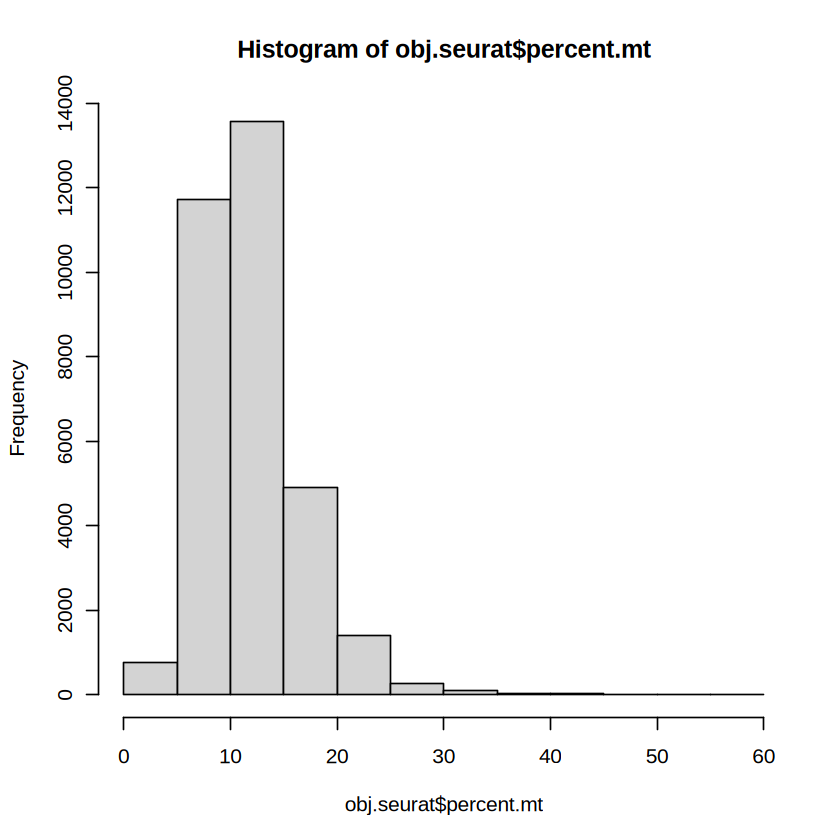

In [20]:
hist(obj.seurat$percent.mt)

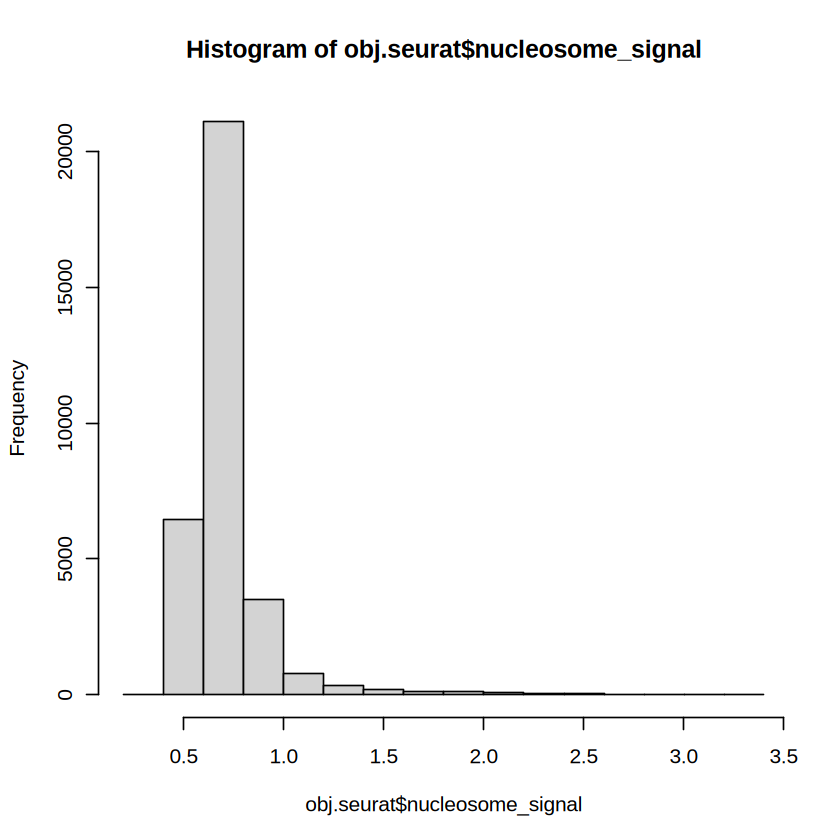

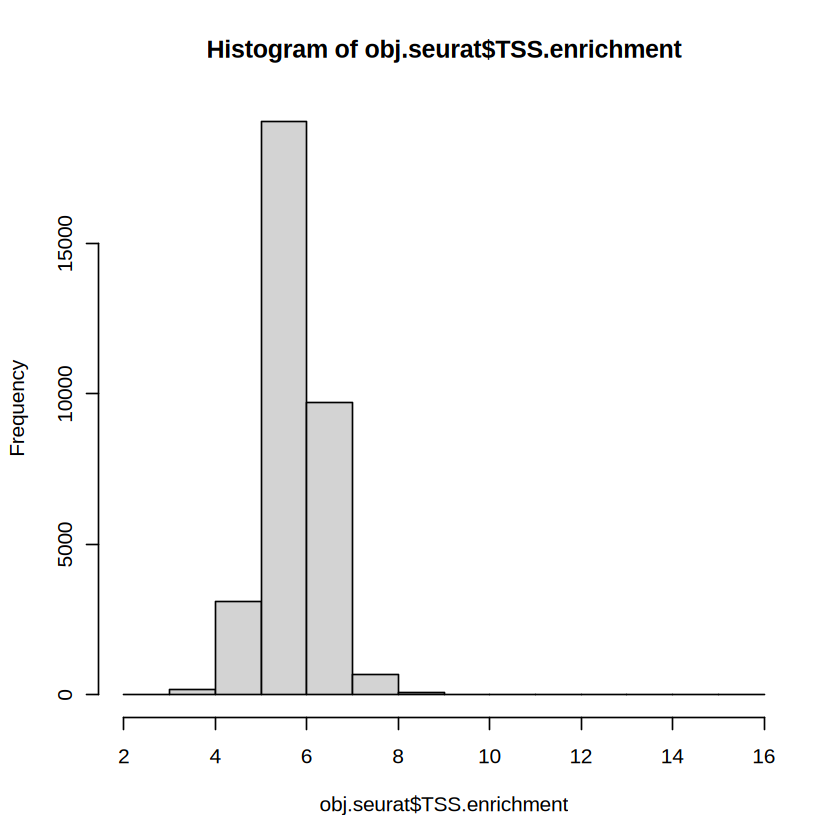

In [21]:
hist(obj.seurat$nucleosome_signal)
hist(obj.seurat$TSS.enrichment)

In [22]:
obj.seurat.qc = subset(obj.seurat,
                       subset = percent.mt < 25 & 
                       nucleosome_signal < 1.5 & 
                       TSS.enrichment > 3)
obj.seurat.qc

An object of class Seurat 
62760 features across 31894 samples within 2 assays 
Active assay: ATAC_empty (3 features, 0 variable features)
 2 layers present: counts, data
 1 other assay present: RNA

In [23]:
summary(obj.seurat.qc$nCount_RNA)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1001    2449    3254    3881    4663   90438 

In [24]:
summary(obj.seurat.qc$nFeature_RNA)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    441    1312    1622    1778    2097   11343 

In [25]:
summary(obj.seurat.qc$atac_fragments)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1001   14181   17908   19681   22225 1287932 

Run UMAP

In [26]:
DefaultAssay(obj.seurat.qc) <- 'RNA'
obj.seurat.qc <- obj.seurat.qc %>%
  NormalizeData() %>%
  FindVariableFeatures() %>%
  ScaleData() %>%
  RunPCA() %>%
  RunUMAP(dims = 1:30)

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  IL32, CD247, IL7R, INPP4B, LTB, RORA, CD69, BACH2, TRBC2, LEF1 
	   BCL2, THEMIS, TRBC1, ANK3, TXK, NELL2, MLLT3, TAFA1, APBA2, LINC01934 
	   NCALD, TSHZ2, PCAT1, PYHIN1, FUT8, CTSW, ENSG00000290067, ICOS, SAMD3, ENSG00000249806 
Negative:  PLXDC2, LRMDA, SLC8A1, FCN1, IRAK3, LYN, MCTP1, TBXAS1, RBM47, TYMP 
	   VCAN, TNFAIP2, GAB2, DMXL2, CSF3R, ZEB2, NAMPT, CLEC7A, LYZ, CYRIA 
	   HCK, SAT1, FGD4, PSAP, PTPRE, TLR2, MNDA, CD36, SLC11A1, RAB31 
PC_ 2 
Positive:  CD247, IL32, SRGN, ANXA1, DPYD, IL7R, INPP4B, TNFAIP3, S100A4, RORA 
	   AOAH, NEAT1, PLCB1, THEMIS, ARHGAP26, TRBC1, FNDC3B, ID2, LEF1, GNAQ 
	   TXK, NCALD, CCL5, ADGRE5, CTSW, TRBC2, TGFBR3, TAFA1, GZMA, NKG7 
Negative:  BANK1, MS4A1, PAX5, IGHM, CD79A, EBF1, FCRL1, LINC00926, AFF3, NIBAN3 
	   OSBPL10, RALGPS2, BLK, CD22, BLNK, COBLL1, ENSG00000251309, ADAM28, IGHD, CD79B 
	   COL19A1, PLEKHG1, WDFY4

In [27]:
obj.seurat.qc <- obj.seurat.qc %>%
  FindNeighbors(dims = 1:30) %>%
  FindClusters()

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 31894
Number of edges: 1189103

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9050
Number of communities: 27
Elapsed time: 5 seconds


In [28]:
dir.create("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/1.seurat_pipeline.240620/",
           recursive = T)

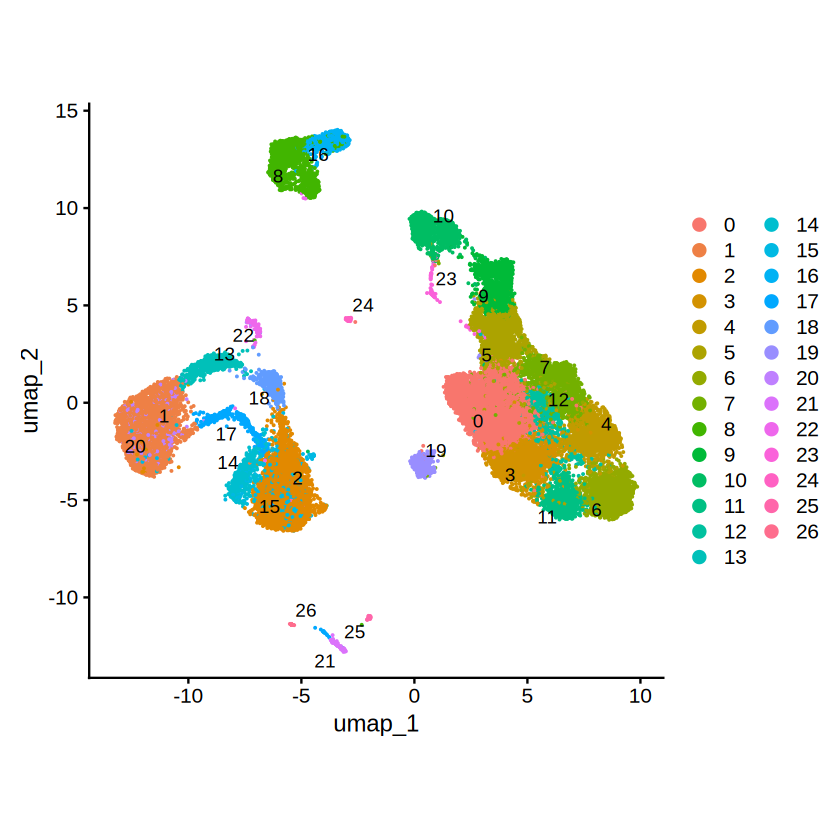

In [29]:
p = DimPlot(obj.seurat.qc, 
        label = TRUE, 
        repel = TRUE, 
        reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/1.seurat_pipeline.240620/UMAP.RNA.pdf", 
       plot = p, 
       width = 10, height = 8)

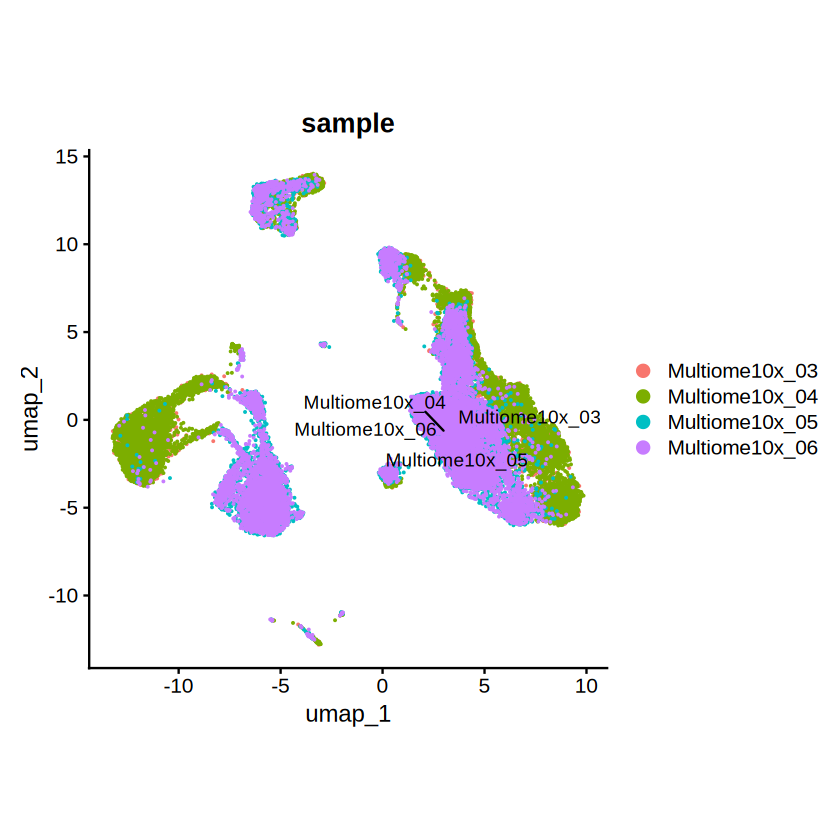

In [32]:
p = DimPlot(obj.seurat.qc, 
            group.by = "sample",
            label = TRUE, 
            repel = TRUE, 
            reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/1.seurat_pipeline.240620/UMAP.RNA.sample.pdf", 
       plot = p, 
       width = 10, height = 8)

In [33]:
table(obj.seurat.qc$sample)


Multiome10x_03 Multiome10x_04 Multiome10x_05 Multiome10x_06 
          2478          11007           9345           9064 

In [34]:
obj.seurat.qc.356 = subset(obj.seurat.qc,
                           subset= sample != "Multiome10x_04")

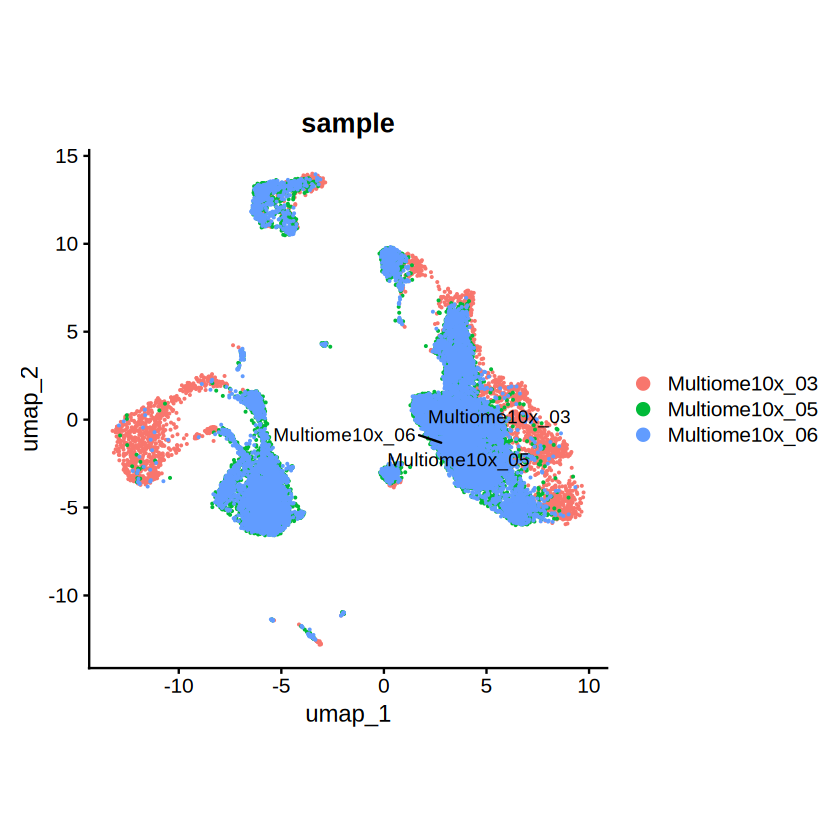

In [35]:
p = DimPlot(obj.seurat.qc.356, 
            group.by = "sample",
            label = TRUE, 
            repel = TRUE, 
            reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/1.seurat_pipeline.240620/UMAP.356.RNA.sample.pdf", 
       plot = p, 
       width = 10, height = 8)

In [36]:
obj.seurat.qc.56 = subset(obj.seurat.qc.356,
                           subset= sample != "Multiome10x_03")

In [37]:
DefaultAssay(obj.seurat.qc) <- 'RNA'
obj.seurat.qc.56 <- obj.seurat.qc.56 %>%
  NormalizeData() %>%
  FindVariableFeatures() %>%
  ScaleData() %>%
  RunPCA() %>%
  RunUMAP(dims = 1:30)

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Warning message:
“Different features in new layer data than already exists for scale.data”
PC_ 1 
Positive:  IL32, CD69, CD247, IL7R, INPP4B, RORA, LTB, TRBC2, BACH2, LEF1 
	   BCL2, THEMIS, TRBC1, ANK3, NELL2, TSHZ2, TAFA1, LINC01934, NCALD, PCAT1 
	   ICOS, ENSG00000290067, PLCL1, CTSW, CCL5, GATA3, ZNF331, LINC01891, ENSG00000249806, ENSG00000287092 
Negative:  PLXDC2, FCN1, LRMDA, SLC8A1, VCAN, LYZ, CSF3R, GAB2, NAMPT, TNFAIP2 
	   TBXAS1, LYN, IRAK3, PSAP, MCTP1, RBM47, CLEC7A, CYRIA, ZEB2, TYMP 
	   PLAUR, DMXL2, PTPRE, CST3, CTSS, KYNU, SULF2, HCK, MNDA, SLC11A1 
PC_ 2 
Positive:  BANK1, MS4A1, CD79A, IGHM, EBF1, PAX5, OSBPL10, LINC00926, RALGPS2, FCRL1 
	   AFF3, ENSG00000251309, NIBAN3, ADAM28, CD79B, CD22, BLK, BLNK, IGHD, COBLL1 
	   PLEKHG1, CCSER1, ADAM7-AS1, WDFY4, RUBCNL, TCF4, KHDRBS2, HLA-DQA1, COL19A1, ANGPTL1 
Negative:  ANXA1, SRGN, IL32, CD247, IL7R, DPYD, INPP

In [38]:
obj.seurat.qc.56 <- obj.seurat.qc.56 %>%
  FindNeighbors(dims = 1:30) %>%
  FindClusters()

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 18409
Number of edges: 704536

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8750
Number of communities: 21
Elapsed time: 3 seconds


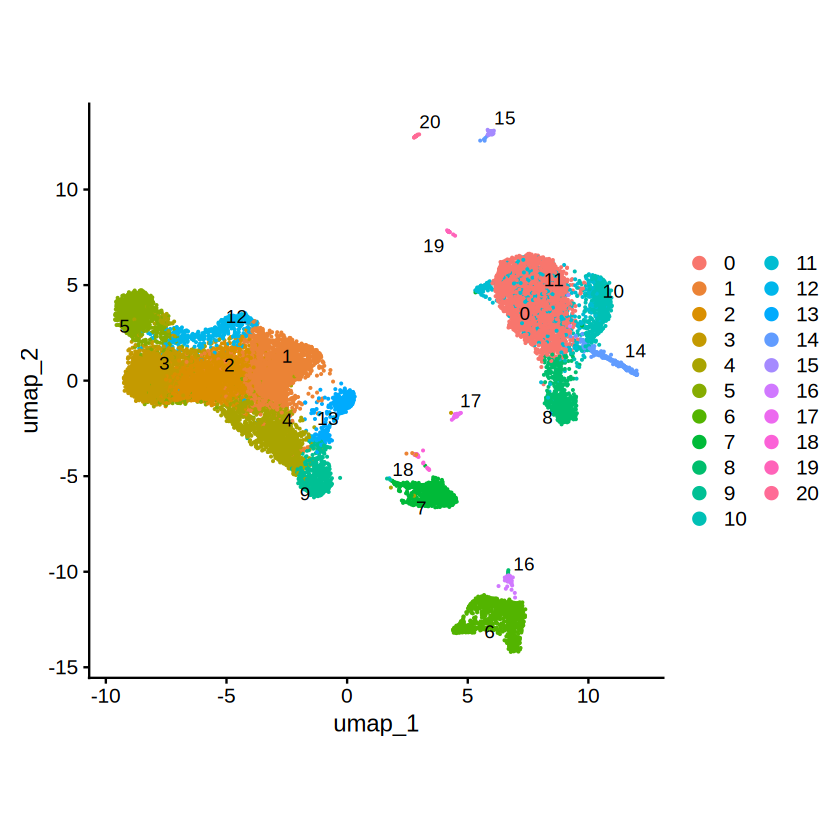

In [39]:
p = DimPlot(obj.seurat.qc.56, 
        label = TRUE, 
        repel = TRUE, 
        reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/1.seurat_pipeline.240620/UMAP.56.RNA.pdf", 
       plot = p, 
       width = 10, height = 8)

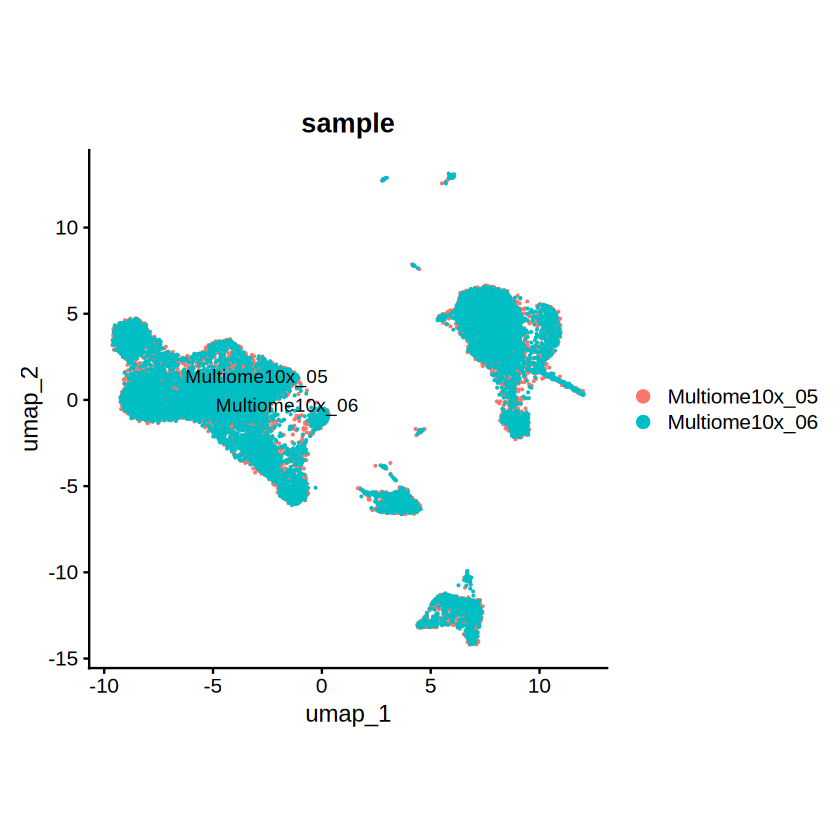

In [40]:
p = DimPlot(obj.seurat.qc.56, 
            group.by = "sample",
            label = TRUE, 
            repel = TRUE, 
            reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/1.seurat_pipeline.240620/UMAP.56.RNA.sample.pdf", 
       plot = p, 
       width = 10, height = 8)

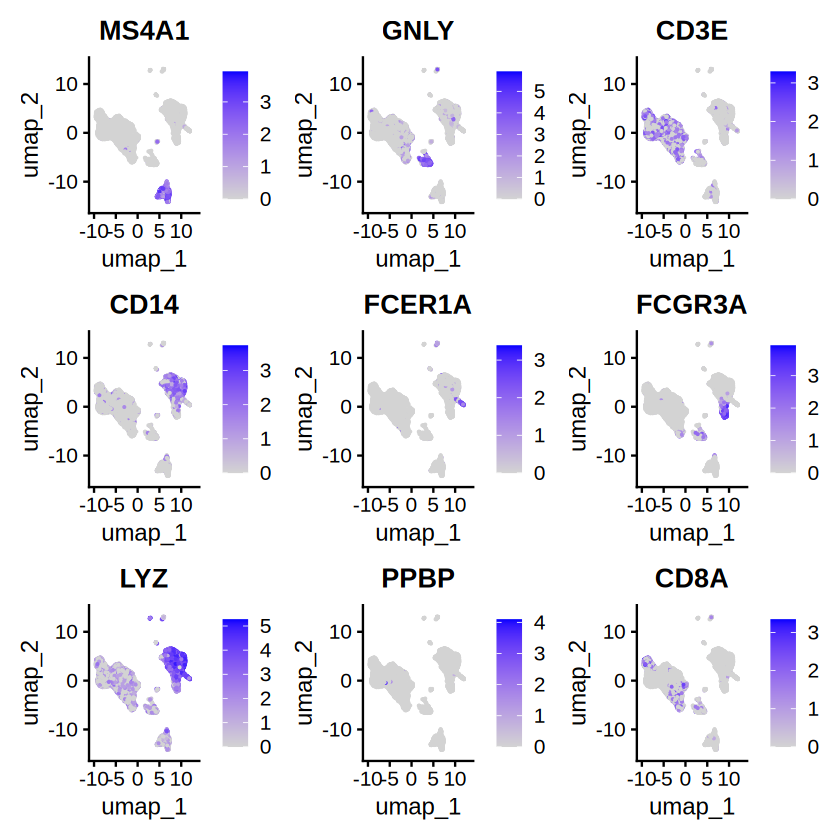

In [52]:
p = FeaturePlot(obj.seurat.qc.56, 
            features = c("MS4A1", # B cell 
                         "GNLY", # NK
                         "CD3E", # T
                         "CD14", 
                         "FCER1A", # DC
                         "FCGR3A", # FCGR3A+ Mono
                         "LYZ", 
                         "PPBP", # Platelet
                         "CD8A" # CD8+ T
                         ))
p
ggsave("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/1.seurat_pipeline.240620/UMAP.56.RNA.marker.pdf", 
       plot = p, 
       width = 22, height = 20)

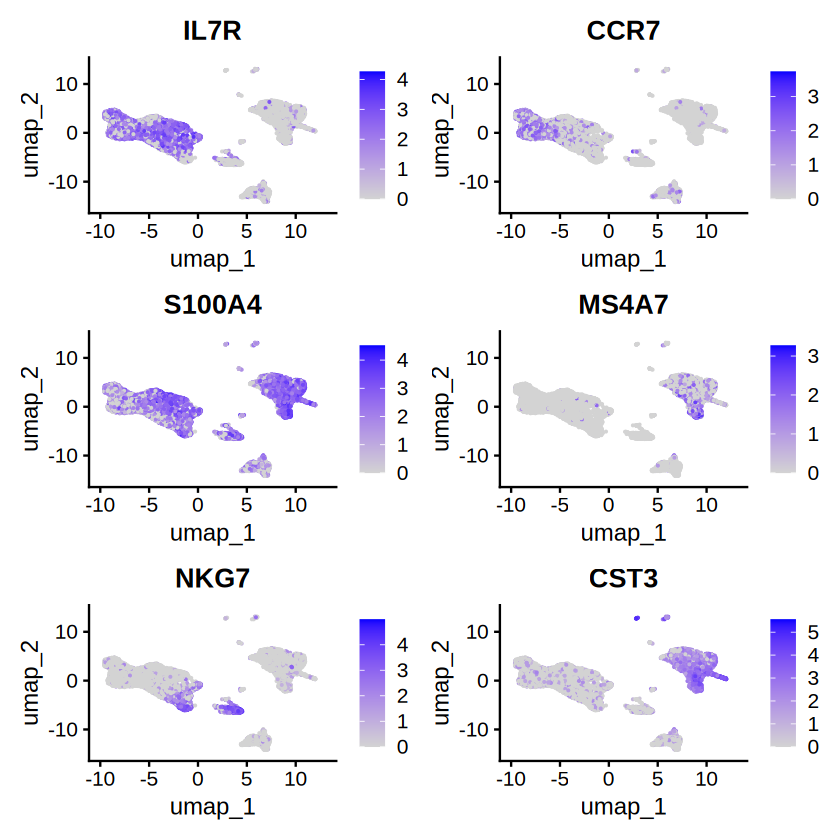

In [54]:
p = FeaturePlot(obj.seurat.qc.56, 
            features = c("IL7R", 
                         "CCR7", 
                         "S100A4", 
                         "MS4A7", 
                         "NKG7", 
                         "CST3"
                         ))
p
ggsave("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/1.seurat_pipeline.240620/UMAP.56.RNA.marker2.pdf", 
       plot = p, 
       width = 15, height = 20)

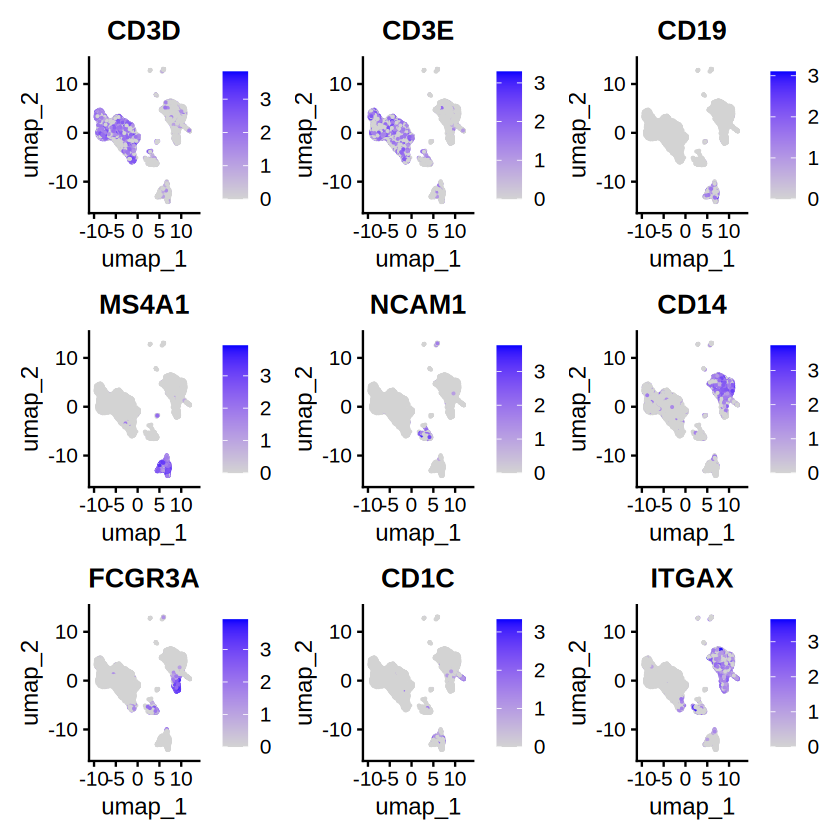

In [60]:
p = FeaturePlot(obj.seurat.qc.56, 
            features = c("CD3D", # T
                         "CD3E", # T
                         "CD19", # B
                         "MS4A1", # CD20 # B
                         "NCAM1", # NK
                         "CD14", # Mono
                         "FCGR3A", # CD16 # Mono
                         "CD1C", # DC
                         "ITGAX" # CD11c # DC
                         ))
p
ggsave("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/1.seurat_pipeline.240620/UMAP.56.RNA.marker3.pdf", 
       plot = p, 
       width = 22, height = 20)


    T  Mono     B    NK    DC    15    17    18    19    20 
11045  4953  1109   774   302    94    58    26    25    23 

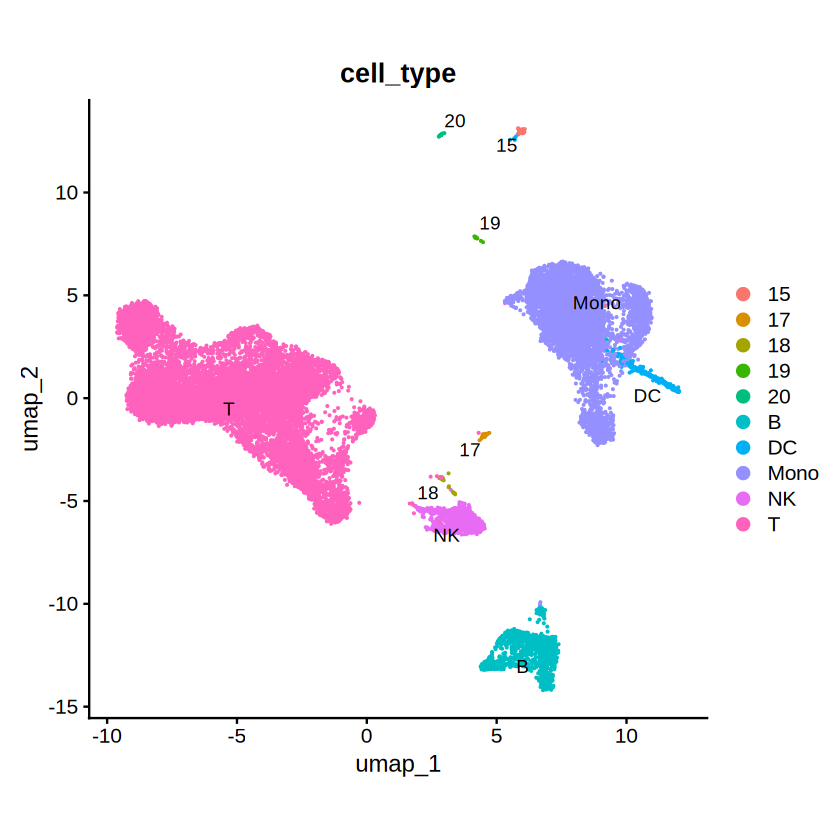

In [66]:
obj.seurat.qc.56$cell_type = as.character(obj.seurat.qc.56$RNA_snn_res.0.8)
obj.seurat.qc.56@meta.data[obj.seurat.qc.56$cell_type %in% c(5,3,2,12,1,4,9,13),"cell_type"] = "T"
obj.seurat.qc.56@meta.data[obj.seurat.qc.56$cell_type %in% c(8,0,11,10),"cell_type"] = "Mono"
obj.seurat.qc.56@meta.data[obj.seurat.qc.56$cell_type %in% c(6,16),"cell_type"] = "B"
obj.seurat.qc.56@meta.data[obj.seurat.qc.56$cell_type %in% c(7),"cell_type"] = "NK"
obj.seurat.qc.56@meta.data[obj.seurat.qc.56$cell_type %in% c(14),"cell_type"] = "DC"

p = DimPlot(obj.seurat.qc.56, 
            group.by = "cell_type",
            label = TRUE, 
            repel = TRUE, 
            reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/1.seurat_pipeline.240620/UMAP.56.RNA.cell_type.pdf", 
       plot = p, 
       width = 10, height = 8)
rev(sort(table(obj.seurat.qc.56$cell_type)))


      T    Mono       B      NK      DC Unknown 
  11045    4953    1109     774     302     226 

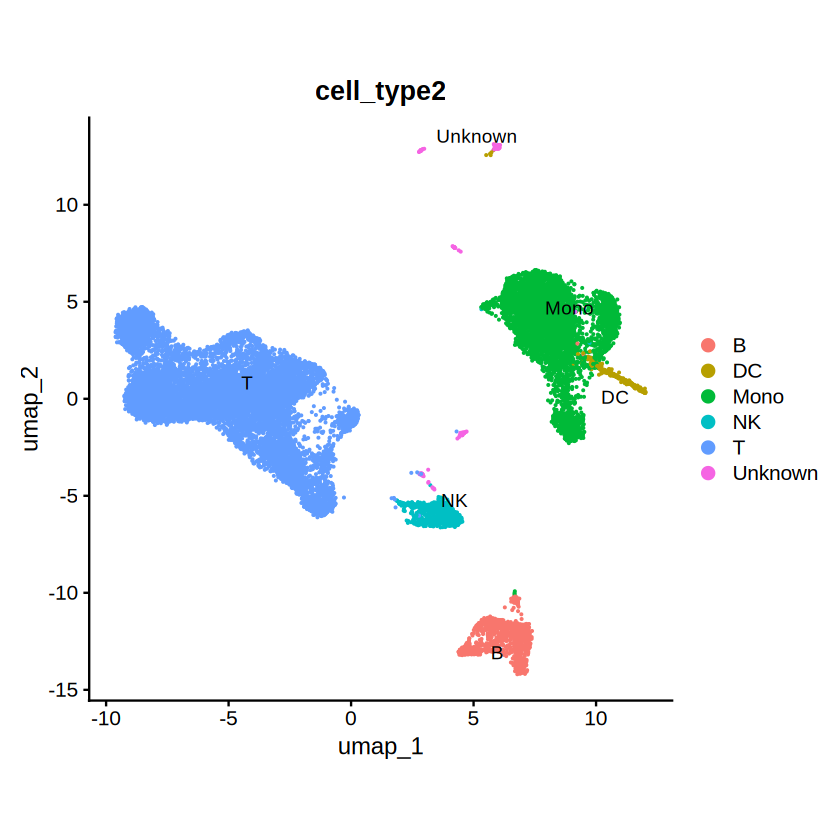

In [67]:
obj.seurat.qc.56$cell_type2 = obj.seurat.qc.56$cell_type
obj.seurat.qc.56@meta.data[obj.seurat.qc.56$cell_type2 %in% c(15,17,18,19,20),"cell_type2"] = "Unknown"


p = DimPlot(obj.seurat.qc.56, 
            group.by = "cell_type2",
            label = TRUE, 
            repel = TRUE, 
            reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/1.seurat_pipeline.240620/UMAP.56.RNA.cell_type2.pdf", 
       plot = p, 
       width = 10, height = 8)
rev(sort(table(obj.seurat.qc.56$cell_type2)))

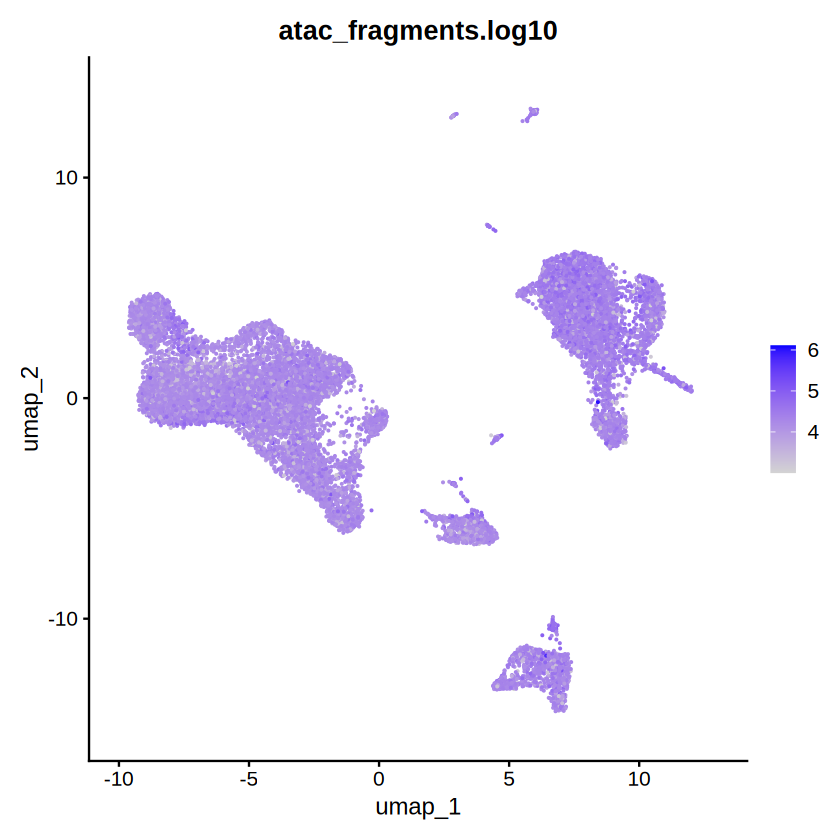

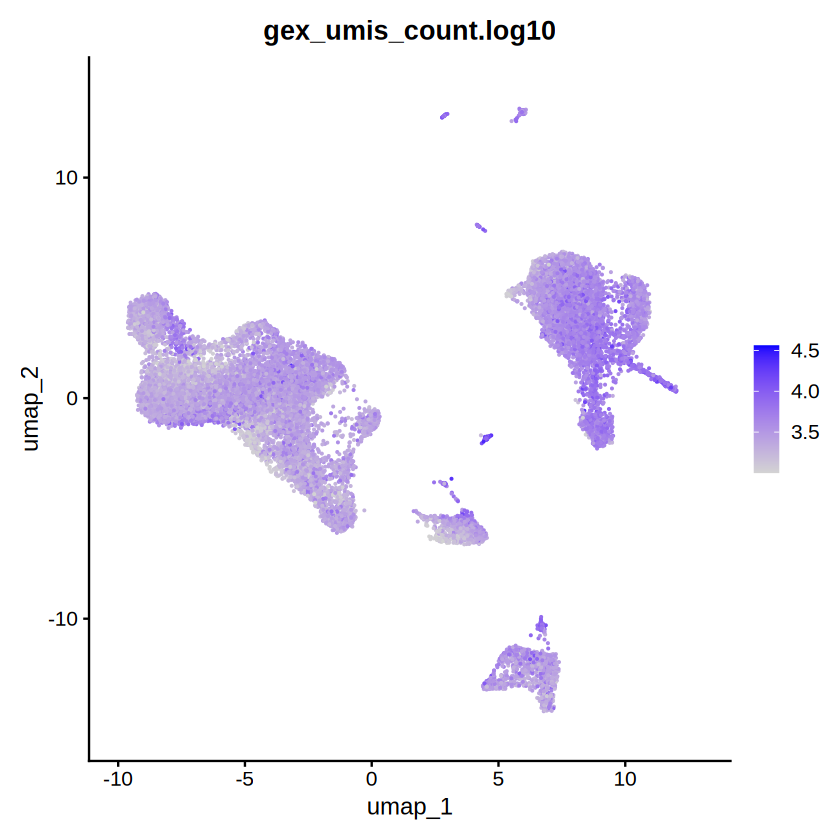

In [68]:
obj.seurat.qc.56$atac_fragments.log10 = log10(obj.seurat.qc.56$atac_fragments)
obj.seurat.qc.56$gex_umis_count.log10 = log10(obj.seurat.qc.56$gex_umis_count)
FeaturePlot(obj.seurat.qc.56, 
            features = c("atac_fragments.log10"))
FeaturePlot(obj.seurat.qc.56, 
            features = c("gex_umis_count.log10"))

In [70]:
dir.create("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/PBMC/1.prepare_data/1.seurat_pipeline.240620/",recursive = T)

In [71]:
saveRDS(obj.seurat.qc.56,
        "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/PBMC/1.prepare_data/1.seurat_pipeline.240620/obj.seurat.qc.56.rds")

In [74]:
obj.seurat.qc.56.filter = subset(obj.seurat.qc.56,
                        subset = cell_type2 != "Unknown")

In [75]:
obj.seurat.qc.56.filter

An object of class Seurat 
62760 features across 18183 samples within 2 assays 
Active assay: RNA (62757 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: ATAC_empty
 2 dimensional reductions calculated: pca, umap

In [76]:
DefaultAssay(obj.seurat.qc.56.filter) <- 'RNA'
obj.seurat.qc.56.filter <- obj.seurat.qc.56.filter %>%
  NormalizeData() %>%
  FindVariableFeatures() %>%
  ScaleData() %>%
  RunPCA() %>%
  RunUMAP(dims = 1:30)

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Warning message:
“Different features in new layer data than already exists for scale.data”
PC_ 1 
Positive:  IL32, CD69, IL7R, CD247, TRAC, CAMK4, INPP4B, RORA, LTB, BACH2 
	   TRBC2, LEF1, BCL2, THEMIS, TRBC1, ABLIM1, ANK3, TXK, NELL2, TSHZ2 
	   MLLT3, TAFA1, LINC01934, NCALD, PCAT1, ICOS, PYHIN1, ENSG00000290067, PLCL1, MAML2 
Negative:  PLXDC2, FCN1, LRMDA, VCAN, SLC8A1, LYZ, CSF3R, GAB2, NAMPT, TNFAIP2 
	   TBXAS1, LYN, IRAK3, PSAP, MCTP1, RBM47, CLEC7A, CYRIA, ZEB2, TYMP 
	   PLAUR, DMXL2, PTPRE, CST3, CTSS, KYNU, SULF2, SLC11A1, MNDA, HCK 
PC_ 2 
Positive:  BANK1, MS4A1, CD79A, EBF1, PAX5, IGHM, LINC00926, OSBPL10, FCRL1, RALGPS2 
	   AFF3, ENSG00000251309, CD79B, CD22, ADAM28, BLK, NIBAN3, IGHD, BLNK, COBLL1 
	   PLEKHG1, CCSER1, ADAM7-AS1, COL19A1, WDFY4, ANGPTL1, RUBCNL, KHDRBS2, FCRL2, HLA-DQA1 
Negative:  SRGN, ANXA1, TNFAIP3, IL32, CD247, IL7R, INPP4B, TRAC, DPYD, CAMK

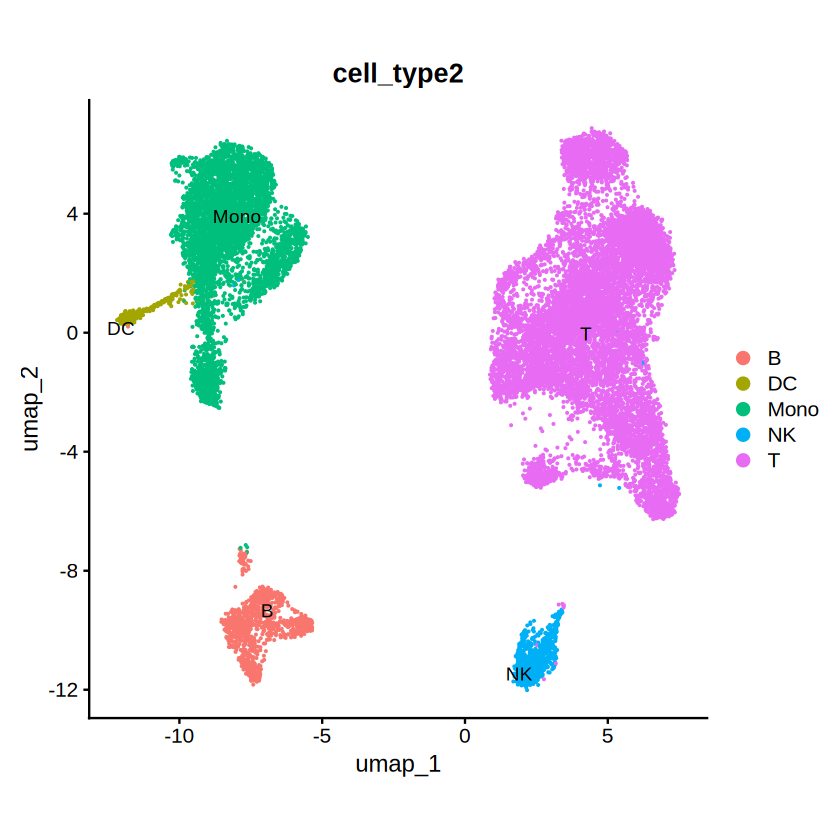

In [77]:
p = DimPlot(obj.seurat.qc.56.filter, 
            group.by = "cell_type2",
            label = TRUE, 
            repel = TRUE, 
            reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/1.seurat_pipeline.240620/UMAP.56.filter.RNA.cell_type2.pdf", 
       plot = p, 
       width = 10, height = 8)

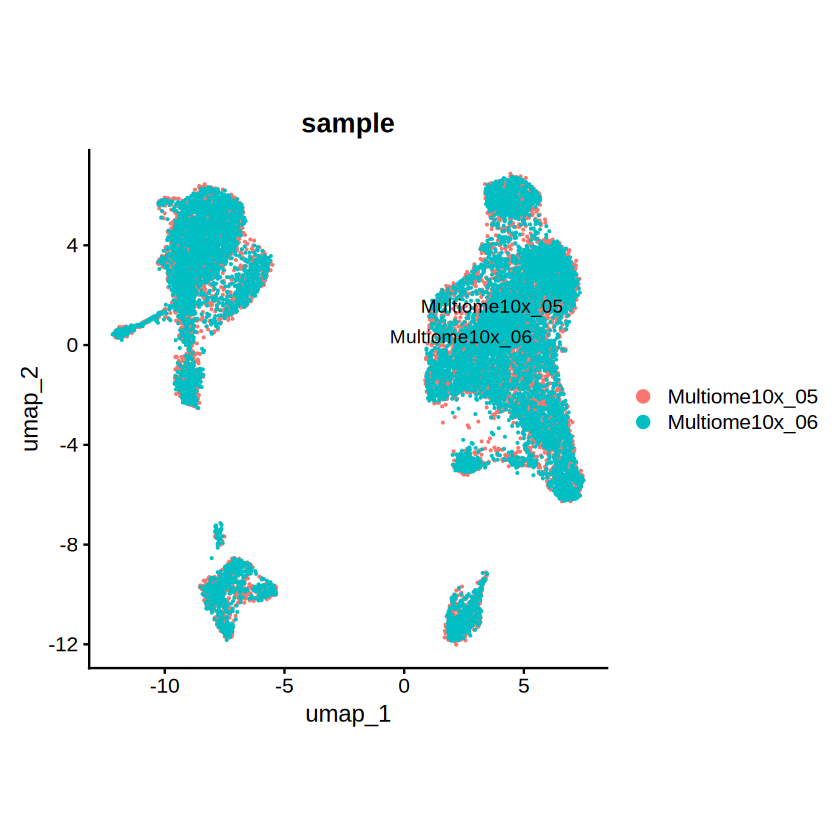

In [78]:
p = DimPlot(obj.seurat.qc.56.filter, 
            group.by = "sample",
            label = TRUE, 
            repel = TRUE, 
            reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/1.seurat_pipeline.240620/UMAP.56.filter.RNA.sample.pdf", 
       plot = p, 
       width = 10, height = 8)

In [80]:
p = FeaturePlot(obj.seurat.qc.56.filter, 
            features = c("CD3D", # T
                         "CD3E", # T
                         "CD19", # B
                         "MS4A1", # CD20 # B
                         "NCAM1", # NK
                         "CD14", # Mono
                         "FCGR3A", # CD16 # Mono
                         "CD1C", # DC
                         "ITGAX" # CD11c # DC
                         ))
ggsave("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/1.seurat_pipeline.240620/UMAP.56.filter.RNA.marker.pdf", 
       plot = p, 
       width = 25, height = 20)

In [81]:
obj.seurat.qc.56.filter

An object of class Seurat 
62760 features across 18183 samples within 2 assays 
Active assay: RNA (62757 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: ATAC_empty
 2 dimensional reductions calculated: pca, umap

In [82]:
table(obj.seurat.qc.56.filter$cell_type)


    B    DC  Mono    NK     T 
 1109   302  4953   774 11045 

In [83]:
summary(obj.seurat.qc.56.filter$nCount_RNA) 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1001    2194    2752    3274    3921   36400 

In [84]:
summary(obj.seurat.qc.56.filter$nFeature_RNA) 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    441    1211    1441    1600    1898    8180 

In [85]:
summary(obj.seurat.qc.56.filter$atac_fragments)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1001   15167   18645   21021   23946 1287932 

In [87]:
saveRDS(obj.seurat.qc.56.filter,
        "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/PBMC/1.prepare_data/1.seurat_pipeline.240620/obj.seurat.qc.56.filter.rds")

Generate fragment files for each cell type

In [89]:
dir_path.frag_split = "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/PBMC/1.prepare_data/1.seurat_pipeline.240620/fragments_split/"
dir.create(dir_path.frag_split,recursive = T)

In [90]:
Signac::SplitFragments(obj.seurat.qc.56.filter,
                      assay = "ATAC_empty",
                      group.by = "cell_type",
                      append = F,
                      outdir = dir_path.frag_split)

Processing file /maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/10x/cellranger_res/Multiome10x_03/outs/atac_fragments.tsv.gz




Processing file /maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/10x/cellranger_res/Multiome10x_04/outs/atac_fragments.tsv.gz




Processing file /maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/10x/cellranger_res/Multiome10x_05/outs/atac_fragments.tsv.gz




Processing file /maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/10x/cellranger_res/Multiome10x_06/outs/atac_fragments.tsv.gz






In [91]:
cell_types = unique(obj.seurat.qc.56.filter$cell_type)
my.cluster <- parallel::makeCluster(
  5,
  type = "PSOCK"
)
doParallel::registerDoParallel(cl = my.cluster)
foreach (n.tmp = 1:length(names.sample)) %dopar% {
  for(name.cell_type in cell_types) {
    cat(name.cell_type,n.tmp,"\n")
    
    path.frag.input = paste(dir_path.frag_split,
                          "/",
                          name.cell_type,
                          ".",
                          n.tmp,
                          ".bed",
                          sep = "")
    path.frag.output = paste(dir_path.frag_split,
                          "/",
                          name.cell_type,
                          ".",
                          n.tmp,
                          ".bed.gz",
                          sep = "")
    if (file.info(path.frag.input)$size > 0) {
      df.frag = 
        read.delim(path.frag.input,
                   header = F)
      df.frag[,4] = paste(names.sample[n.tmp],
                          df.frag[,4],
                          sep = "_")
      write.table(df.frag,
              gzfile(path.frag.output),
              col.names = F,
              row.names = F,
              quote = F,
              sep = "\t")

    }
  }
}
parallel::stopCluster(cl = my.cluster)

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

Generate RNA count matrix for each cell type

In [92]:
dir_path.rna_matrix = "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/PBMC/1.prepare_data/1.seurat_pipeline.240620/RNA_count_matrix/"
dir.create(dir_path.rna_matrix,recursive = T)

In [93]:
for(name.cell_type in unique(obj.seurat.qc.56.filter$cell_type)){
  matrix.tmp = 
    obj.seurat.qc.56.filter@assays$RNA$count[,obj.seurat.qc.56.filter$cell_type == name.cell_type]
  write.csv(as.data.frame(matrix.tmp),
            gzfile(paste(dir_path.rna_matrix,
                         "/",
                         name.cell_type,
                         ".rna_count_matrix.csv.gz",
                        sep = "")),
            quote = F)
}

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 5.2 GiB”


In [94]:
write.csv(t(as.data.frame(obj.seurat.qc.56.filter@assays$RNA$count)),
          gzfile("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/PBMC/1.prepare_data/1.seurat_pipeline.240620//rna_count_matrix.t.csv.gz"),
          quote = F)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 8.5 GiB”


In [95]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux 8.10 (Ootpa)

Matrix products: default
BLAS/LAPACK: /maps/projects/ralab/people/lpm537/software/anaconda3/envs/Notebook_E2G_240505/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Copenhagen
tzcode source: system (glibc)

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] foreach_1.5.2        Rsamtools_2.18.0     Biostrings_2.70.1   
 [4] XVector_0.42.0       GenomicRanges_1.54.1 GenomeI

In [2]:
obj.seurat.qc.56.filter = readRDS("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/PBMC/1.prepare_data/1.seurat_pipeline.240620/obj.seurat.qc.56.filter.rds")

In [3]:
df.cell_type = data.frame(cell_type = names(table(obj.seurat.qc.56.filter$cell_type)),
                          cell_number = table(obj.seurat.qc.56.filter$cell_type),
                          total_fragment_count = NA,
                          total_UMI_count = NA)
rownames(df.cell_type) = df.cell_type$cell_type

In [4]:
for(cell_type.tmp in df.cell_type$cell_type){
    cell_names.tmp = colnames(obj.seurat.qc.56.filter)[obj.seurat.qc.56.filter@meta.data$cell_type == cell_type.tmp]
    df.cell_type[cell_type.tmp,"total_fragment_count"] = sum(obj.seurat.qc.56.filter@meta.data[cell_names.tmp,"atac_fragments"])
    df.cell_type[cell_type.tmp,"total_UMI_count"] = sum(obj.seurat.qc.56.filter@meta.data[cell_names.tmp,"gex_umis_count"])
}

In [5]:
df.cell_type$mean_fragment_count = round(df.cell_type$total_fragment_count / df.cell_type$cell_number.Freq,0)
df.cell_type$mean_UMI_count = round(df.cell_type$total_UMI_count / df.cell_type$cell_number.Freq,0)

In [6]:
write.csv(df.cell_type,
          "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/PBMC/1.prepare_data/1.seurat_pipeline.240620/df.cell_type.csv")